<a href="https://colab.research.google.com/github/minhbao1705/AIO2023_HOMEWORK/blob/main/231119_Scenes_cls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0 . Download dataset

In [1]:
!gdown 1QEGqmIP0pxQuATj1aqmyW1Fk1suq7LYK

Downloading...
From: https://drive.google.com/uc?id=1QEGqmIP0pxQuATj1aqmyW1Fk1suq7LYK
To: /content/img_cls_scenes_classification.zip
100% 255M/255M [00:03<00:00, 75.4MB/s]


In [2]:
!unzip /content/img_cls_scenes_classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: scenes_classification/train/mountain/16162.jpg  
  inflating: scenes_classification/train/mountain/16173.jpg  
  inflating: scenes_classification/train/mountain/16225.jpg  
  inflating: scenes_classification/train/mountain/16322.jpg  
  inflating: scenes_classification/train/mountain/16341.jpg  
  inflating: scenes_classification/train/mountain/16350.jpg  
  inflating: scenes_classification/train/mountain/16374.jpg  
  inflating: scenes_classification/train/mountain/16375.jpg  
  inflating: scenes_classification/train/mountain/16417.jpg  
  inflating: scenes_classification/train/mountain/1642.jpg  
  inflating: scenes_classification/train/mountain/16421.jpg  
  inflating: scenes_classification/train/mountain/16438.jpg  
  inflating: scenes_classification/train/mountain/16560.jpg  
  inflating: scenes_classification/train/mountain/16599.jpg  
  inflating: scenes_classification/train/mountain/16645.jpg  
  inflating: scenes_

### 1. Import libraries

In [3]:
import torch
import torch.nn as nn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

### 2. Read dataset

In [4]:
root_dir = '/content/scenes_classification'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'val')

classes = {
    label_idx: class_name \
      for label_idx, class_name in enumerate(
          sorted(os.listdir(train_dir))
      )
}

In [5]:
X_train = []
y_train = []
X_test = []
y_test = []

for dataset_path in [train_dir, test_dir]:
  for label_idx, class_name in classes.items():
    class_dir = os.path.join(dataset_path, class_name)
    for img_filename in os.listdir(class_dir):
      img_path = os.path.join(class_dir, img_filename)
      if 'train' in dataset_path:
        X_train.append(img_path)
        y_train.append(label_idx)
      else:
        X_test.append(img_path)
        y_test.append(label_idx)

### 3. Train, val, test split

In [6]:
seed = 0
val_size = 0.2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

### 4. Create pytorch dataset

In [7]:
class ScenesDataset(Dataset):
  def __init__(
      self,
      X, y,
      transform=None
  ):
    self.transform = transform
    self.img_paths = X
    self.labels = y

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    img = Image.open(img_path).convert("RGB")

    if self.transform:
      img = self.transform(img)

    return img, self.labels[idx]

### 5. Create data preprocessing function

In [8]:
def transform(img, img_size=(224, 224)):
  img = img.resize(img_size)
  img = np.array(img)[..., :3]
  img = torch.tensor(img).permute(2, 0, 1).float()
  normalized_img = img / 255.0

  return normalized_img

### 6. Create dataloader

Khai báo datasets object cho ba bộ train, val, test

In [9]:
train_dataset = ScenesDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = ScenesDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = ScenesDataset(
    X_test, y_test,
    transform=transform
)

Khai báo dataloader:

In [10]:
train_batch_size = 64
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


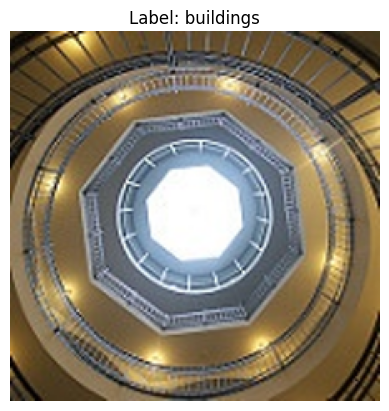

In [11]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

### 7. Create model

In [12]:
import torch
import torch.nn as nn

class BottleneckBlock(nn.Module):
  def __init__(self, in_channels, growth_rate):
    super(BottleneckBlock, self).__init__()
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
    self.bn2 = nn.BatchNorm2d(4 * growth_rate)
    self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
    self.relu = nn.ReLU()

  def forward(self, x):
    res = x.clone().detach()
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv1(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = torch.cat([res, x], 1)

    return x

class DenseBlock(nn.Module):
  def __init__(self, num_layers, in_channels, growth_rate):
    super(DenseBlock, self).__init__()
    layers = []
    for i in range(num_layers):
      layers.append(BottleneckBlock(in_channels + i * growth_rate, growth_rate))
      self.block = nn.Sequential(*layers)

  def forward(self, x):
    return self.block(x)

In [13]:
class DenseNet(nn.Module):
  def __init__(self, num_blocks, growth_rate, num_classes):
    super(DenseNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 2 * growth_rate, kernel_size=7, padding=3, stride=2, bias=False)
    self.bn1 = nn.BatchNorm2d(2 * growth_rate)
    self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.dense_blocks = nn.ModuleList()
    in_channels = 2 * growth_rate
    for i, num_layers in enumerate(num_blocks):
      self.dense_blocks.append(DenseBlock(num_layers, in_channels, growth_rate))
      in_channels += num_layers * growth_rate
      if i != len(num_blocks) - 1:
        out_channels = in_channels // 2
        self.dense_blocks.append(nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        ))
        in_channels = out_channels

    self.bn2 = nn.BatchNorm2d(in_channels)
    self.pool2 = nn.AvgPool2d(kernel_size=7)
    self.relu = nn.ReLU()
    self.fc = nn.Linear(in_channels, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)

    for block in self.dense_blocks:
      x = block(x)

    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool2(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

In [16]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = DenseNet(
    [6, 12, 24, 16],
    growth_rate=32,
    num_classes=n_classes
).to(device)


In [17]:
model.eval()
dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
  output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([1, 6])


### 8. Training

In [18]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  loss = sum(losses) / len(losses)
  acc = correct / total

  return loss, acc

In [19]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    batch_train_losses = []

    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      batch_train_losses.append(loss.item())

    train_loss = sum(batch_train_losses) / len(batch_train_losses)
    train_losses.append(train_loss)

    val_loss, val_acc = evaluate(
        model, val_loader,
        criterion, device
    )
    val_losses.append(val_loss)

    print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

  return train_losses, val_losses

In [20]:
lr = 1e-3
epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)

In [21]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 1.7117	Val loss: 1.6497
EPOCH 2:	Train loss: 1.6087	Val loss: 1.5632
EPOCH 3:	Train loss: 1.5361	Val loss: 1.4996
EPOCH 4:	Train loss: 1.4792	Val loss: 1.4485
EPOCH 5:	Train loss: 1.4374	Val loss: 1.4093
EPOCH 6:	Train loss: 1.4002	Val loss: 1.3772
EPOCH 7:	Train loss: 1.3740	Val loss: 1.3505
EPOCH 8:	Train loss: 1.3483	Val loss: 1.3236
EPOCH 9:	Train loss: 1.3254	Val loss: 1.3016
EPOCH 10:	Train loss: 1.3054	Val loss: 1.2857
EPOCH 11:	Train loss: 1.2867	Val loss: 1.2686
EPOCH 12:	Train loss: 1.2709	Val loss: 1.2525
EPOCH 13:	Train loss: 1.2608	Val loss: 1.2389
EPOCH 14:	Train loss: 1.2453	Val loss: 1.2251
EPOCH 15:	Train loss: 1.2314	Val loss: 1.2162
EPOCH 16:	Train loss: 1.2240	Val loss: 1.2074
EPOCH 17:	Train loss: 1.2108	Val loss: 1.1951
EPOCH 18:	Train loss: 1.2012	Val loss: 1.1854
EPOCH 19:	Train loss: 1.1933	Val loss: 1.1761
EPOCH 20:	Train loss: 1.1857	Val loss: 1.1690
EPOCH 21:	Train loss: 1.1764	Val loss: 1.1598
EPOCH 22:	Train loss: 1.1667	Val loss: 1.15

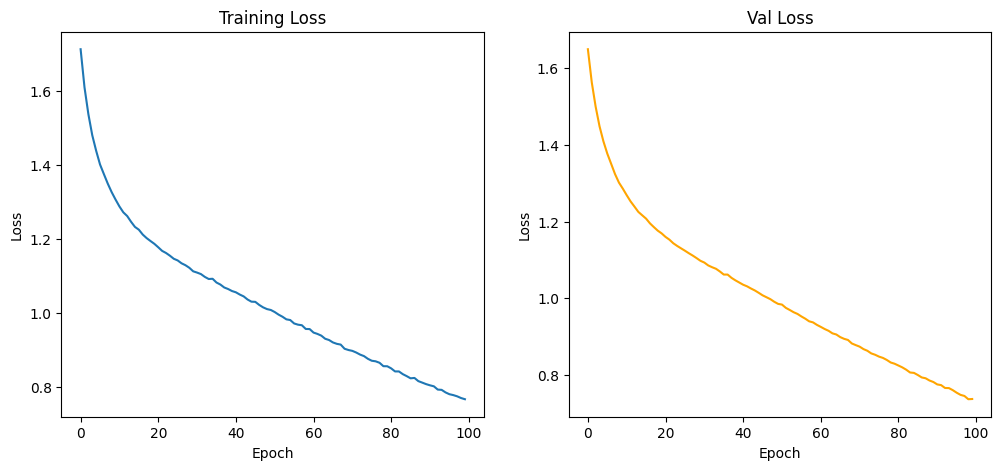

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

### 9. Evaluation

In [23]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.740179923398949
Test accuracy:  0.7133333333333334
